In [40]:
import pickle
import os
import matplotlib.pyplot as plt

def load_environment_data():
    """
    Loads place cell, reward cell network data, environment data,
    and hmaps, including vanilla and multiscale hmaps with alpha.

    Returns:
    - data (dict): A dictionary containing network data, environment variables, and hmaps.
    """
    data = {}
    world_name = "world0_20x20-obstacles"

    # Define directories for PKL and HMAPS
    network_dir = f"pkl/networks/{world_name}"
    hmaps_dir = f"pkl/hmaps/{world_name}"
    vanilla_path_dir = f"analysis/stats/vanilla/{world_name}/hmaps"
    multiscale_path_dir = f"analysis/stats/multiscale/{world_name}/hmaps"

    # Load small PCN
    try:
        with open(f"{network_dir}/pcn_small.pkl", "rb") as f:
            data["small_pc_net"] = pickle.load(f)
        print("Loaded small PCN.")
    except FileNotFoundError:
        print("Error: small PCN file not found.")
        return None

    # Load large PCN (if available)
    try:
        with open(f"{network_dir}/pcn_large.pkl", "rb") as f:
            data["large_pc_net"] = pickle.load(f)
        print("Loaded large PCN.")
        data["has_large_pcn"] = True
    except FileNotFoundError:
        print("Large PCN file not found. Assuming single-scale setup.")
        data["has_large_pcn"] = False

    # Load small RCN
    try:
        with open(f"{network_dir}/rcn_small.pkl", "rb") as f:
            data["rc_net_small"] = pickle.load(f)
        print("Loaded small RCN.")
    except FileNotFoundError:
        print("Error: small RCN file not found.")
        data["rc_net_small"] = None

    # Load large RCN (if applicable)
    if data.get("has_large_pcn", False):
        try:
            with open(f"{network_dir}/rcn_large.pkl", "rb") as f:
                data["rc_net_large"] = pickle.load(f)
            print("Loaded large RCN.")
        except FileNotFoundError:
            print("Large RCN file not found. Assuming single-scale setup.")
            data["rc_net_large"] = None

    # Load vanilla hmaps
    data["vanilla_hmaps"] = {}
    if os.path.exists(vanilla_path_dir):
        for file_name in os.listdir(vanilla_path_dir):
            if "hmap_x" in file_name or "hmap_y" in file_name:
                # Parse trial and corner information from filename
                parts = file_name.split('_')
                if len(parts) >= 6:  # Ensure filename has enough parts
                    trial_id = parts[1]
                    corner_x = parts[3]
                    corner_y = parts[4]
                    corner_id = f"{corner_x}_{corner_y}"
                    
                    # Initialize nested dictionaries if they don't exist
                    if corner_id not in data["vanilla_hmaps"]:
                        data["vanilla_hmaps"][corner_id] = {}
                    if trial_id not in data["vanilla_hmaps"][corner_id]:
                        data["vanilla_hmaps"][corner_id][trial_id] = {}
                    
                    # Load the hmap
                    with open(os.path.join(vanilla_path_dir, file_name), "rb") as f:
                        if "hmap_x" in file_name:
                            data["vanilla_hmaps"][corner_id][trial_id]["hmap_x"] = pickle.load(f)
                        elif "hmap_y" in file_name:
                            data["vanilla_hmaps"][corner_id][trial_id]["hmap_y"] = pickle.load(f)
        print("Loaded vanilla path hmaps.")

    # Load multiscale hmaps (including alpha)
    data["multiscale_hmaps"] = {}
    if os.path.exists(multiscale_path_dir):
        for file_name in os.listdir(multiscale_path_dir):
            if "hmap_x" in file_name or "hmap_y" in file_name or "hmap_alpha" in file_name:
                # Parse trial and corner information from filename
                parts = file_name.split('_')
                if len(parts) >= 6:  # Ensure filename has enough parts
                    trial_id = parts[1]
                    corner_x = parts[3]
                    corner_y = parts[4]
                    corner_id = f"{corner_x}_{corner_y}"
                    
                    # Initialize nested dictionaries if they don't exist
                    if corner_id not in data["multiscale_hmaps"]:
                        data["multiscale_hmaps"][corner_id] = {}
                    if trial_id not in data["multiscale_hmaps"][corner_id]:
                        data["multiscale_hmaps"][corner_id][trial_id] = {}
                    
                    # Load the hmap or alpha
                    with open(os.path.join(multiscale_path_dir, file_name), "rb") as f:
                        if "hmap_x" in file_name:
                            data["multiscale_hmaps"][corner_id][trial_id]["hmap_x"] = pickle.load(f)
                        elif "hmap_y" in file_name:
                            data["multiscale_hmaps"][corner_id][trial_id]["hmap_y"] = pickle.load(f)
                        elif "hmap_alpha" in file_name:
                            data["multiscale_hmaps"][corner_id][trial_id]["hmap_alpha"] = pickle.load(f)

        print("Loaded multiscale path hmaps.")

    # Load DMTP path hmaps
    dmtp_path_dir = f"analysis/stats/multiscale/{world_name}/DMTP_paths"
    data["dmtp_hmaps"] = {}

    dmtp_files = [
        ("-9_9_hmap_x_dmtp.pkl", "-9_9_hmap_y_dmtp.pkl"),
        ("9_-9_hmap_x_dmtp.pkl", "9_-9_hmap_y_dmtp.pkl"),
    ]

    for x_file, y_file in dmtp_files:
        corner_id = x_file.split("_hmap")[0]  # Extracts "-9_9" or "9_-9"
        data["dmtp_hmaps"][corner_id] = {}

        try:
            with open(os.path.join(dmtp_path_dir, x_file), "rb") as f:
                data["dmtp_hmaps"][corner_id]["hmap_x"] = pickle.load(f)
            with open(os.path.join(dmtp_path_dir, y_file), "rb") as f:
                data["dmtp_hmaps"][corner_id]["hmap_y"] = pickle.load(f)
            print(f"Loaded DMTP hmaps for corner {corner_id}.")
        except FileNotFoundError:
            print(f"Error: DMTP path files missing for {corner_id}.")

    # Load environment data
    environment_files = {
        "hmap_x": f"{hmaps_dir}/hmap_x.pkl",
        "hmap_y": f"{hmaps_dir}/hmap_y.pkl",
        "hmap_z_small": f"{hmaps_dir}/hmap_z_small.pkl",
    }

    for key, filepath in environment_files.items():
        try:
            with open(filepath, "rb") as f:
                data[key] = pickle.load(f)
            print(f"Loaded {key}.")
        except FileNotFoundError:
            print(f"Error: {filepath} not found.")
            return None

    # Load large-scale place cell activations (if applicable)
    if data.get("has_large_pcn", False):
        try:
            with open(f"{hmaps_dir}/hmap_z_large.pkl", "rb") as f:
                data["hmap_z_large"] = pickle.load(f)
            print("Loaded hmap_z_large.")
        except FileNotFoundError:
            print("hmap_z_large file not found. Assuming single-scale setup.")
            data["hmap_z_large"] = None

    

    # Set goal properties
    data["goal_r"] = 0.8  # Goal radius
    data["goal_location"] = [-2, 2]  # Goal location

    return data

data = load_environment_data()

Loaded small PCN.
Loaded large PCN.
Loaded small RCN.
Loaded large RCN.
Loaded vanilla path hmaps.
Loaded multiscale path hmaps.
Loaded DMTP hmaps for corner -9_9.
Loaded DMTP hmaps for corner 9_-9.
Loaded hmap_x.
Loaded hmap_y.
Loaded hmap_z_small.
Loaded hmap_z_large.


In [2]:
def save_plot_to_directory(fig, background_path, path_type, plot_type_folder, corner_id):
    """
    Saves the plot to a specified directory structure.
    
    Args:
    - fig: The matplotlib figure object.
    - background_path (str): Path to the background image, used to determine the world name.
    - path_type (str): Type of path ('vanilla' or 'multiscale').
    - plot_type_folder (str): Subfolder name to save plots (e.g., 'gradient', 'trajectory').
    - corner_id (str): Corner ID to include in the filename for specificity.
    """
    # Extract the world name from the background path
    world_name = os.path.splitext(os.path.basename(background_path))[0]

    # Create the directory structure
    base_dir = os.path.join("analysis", "stats", path_type, world_name, plot_type_folder)
    os.makedirs(base_dir, exist_ok=True)

    # Construct the filename
    filename = f"{corner_id}_trajectory_plot.png"
    file_path = os.path.join(base_dir, filename)

    # Save the figure
    fig.savefig(file_path, dpi=300, bbox_inches="tight")
    print(f"Plot saved to: {file_path}")

# Plot PCN

In [3]:
import numpy as np
from matplotlib.cm import get_cmap

def probeOne(probed, layer, data, world_id):
    """Updated to save the plot after visualizing."""
    hmap_x = data['hmap_x']
    hmap_y = data['hmap_y']
    cmap = get_cmap("plasma")

    if layer == "small":
        activations = data['hmap_z_small'][:, probed]
        title = f"Place Cell {probed} Activation (Small Layer)"
        scale = "vanilla"
    elif layer == "large":
        if not data.get('has_large_pcn', False):
            print("Large layer not available. Skipping visualization.")
            return
        activations = data['hmap_z_large'][:, probed]
        title = f"Place Cell {probed} Activation (Large Layer)"
        scale = "multiscale"
    else:
        raise ValueError("Layer must be either 'small' or 'large'.")

    # Plot the activations
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect("equal")

    # Create a hexbin plot for place cell activations
    cntr = ax.hexbin(hmap_x, hmap_y, activations, gridsize=50, cmap=cmap, alpha=0.6)

    # Add colorbar and title
    plt.colorbar(cntr)
    plt.title(title)

    plt.show()


# # Calculate the total activation for the small layer
# total_activations_small = np.sum(data['hmap_z_small'], axis=0)
# top_cells_small = np.argsort(total_activations_small)[-10:]

# # Visualize the top 10 cells in the small layer
# for cell in top_cells_small:
#     probeOne(cell, "small", data, "world5")

# # Calculate and visualize the large layer only if it exists
# if data.get('has_large_pcn', False) and data.get('hmap_z_large') is not None:
#     total_activations_large = np.sum(data['hmap_z_large'], axis=0)
#     top_cells_large = np.argsort(total_activations_large)[-10:]
#     for cell in top_cells_large:
#         probeOne(cell, "large", data, "world5")
# else:
#     print("Large layer not available. Skipping large-scale visualizations.")


# Plot RCN Side By Side (small)

C:\Users\bduke\AppData\Local\Temp\ipykernel_21324\56928061.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("plasma")


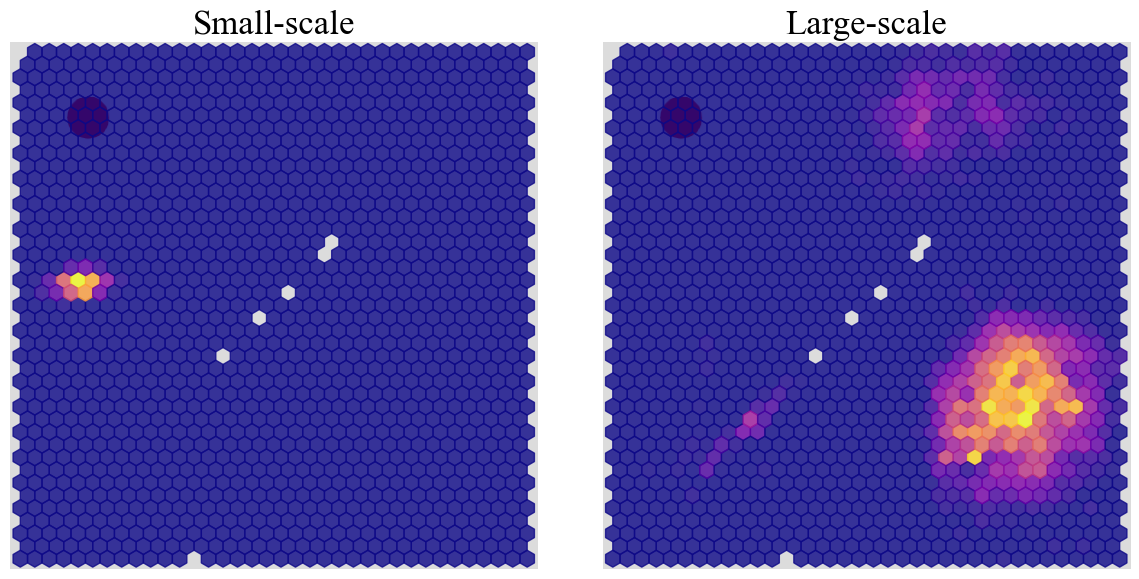

In [4]:
from PIL import Image, ImageOps
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams['font.family'] = 'Times New Roman'

def probeOne_with_background(ax, probed, layer, data, background_path, rotation_angle=0, buffer=0.5):
    hmap_x = data['hmap_x']
    hmap_y = data['hmap_y']
    cmap = get_cmap("plasma")

    if layer == "small":
        activations = data['hmap_z_small'][:, probed]
    elif layer == "large":
        if not data.get('has_large_pcn', False):
            print("Large layer not available. Skipping visualization.")
            return
        activations = data['hmap_z_large'][:, probed]
    else:
        raise ValueError("Layer must be either 'small' or 'large'.")

    img = Image.open(background_path)
    img = ImageOps.flip(img)
    img = img.rotate(rotation_angle, expand=True)
    img = np.array(img)

    extent = [
        hmap_x.min() - buffer, hmap_x.max() + buffer,
        hmap_y.min() - buffer, hmap_y.max() + buffer,
    ]

    ax.imshow(img, extent=extent, aspect='auto')
    ax.hexbin(hmap_x, hmap_y, activations, gridsize=35, cmap=cmap, alpha=0.8)
    ax.set_aspect('equal', adjustable='box')
    ax.set_axis_off()


def plot_place_cells_side_by_side(data, cell_small_alias, cell_large_alias, background_path, world_id):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    cell_small = top_cells_small[cell_small_alias - 1] if cell_small_alias <= len(top_cells_small) else None
    cell_large = top_cells_large[cell_large_alias - 1] if cell_large_alias <= len(top_cells_large) else None

    if cell_small is not None:
        probeOne_with_background(axes[0], cell_small, "small", data, background_path, buffer=0.4)
        axes[0].set_title(f"Small-scale", fontsize=25)
    else:
        axes[0].set_title("Small-scale Layer - No Data", fontsize=25)

    if cell_large is not None:
        probeOne_with_background(axes[1], cell_large, "large", data, background_path, buffer=0.4)
        axes[1].set_title(f"Large-scale", fontsize=25)
    else:
        axes[1].set_title("Large-scale Layer - No Data", fontsize=25)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


total_activations_small = np.sum(data['hmap_z_small'], axis=0)
top_cells_small = np.argsort(total_activations_small)[-50:][::-1]

total_activations_large = []
top_cells_large = []
if data.get('has_large_pcn', False) and data.get('hmap_z_large') is not None:
    total_activations_large = np.sum(data['hmap_z_large'], axis=0)
    top_cells_large = np.argsort(total_activations_large)[-10:][::-1]

cell_small_alias = 26  # Index 1-10 for small layer
cell_large_alias = 9  # Index 1-10 for large layer

background_path = "images/world0_20x20.png"
plot_place_cells_side_by_side(data=data, cell_small_alias=cell_small_alias, cell_large_alias=cell_large_alias, background_path=background_path, world_id="world0")


# Plot RCN Side By Side

C:\Users\bduke\AppData\Local\Temp\ipykernel_21324\1232105666.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("plasma")


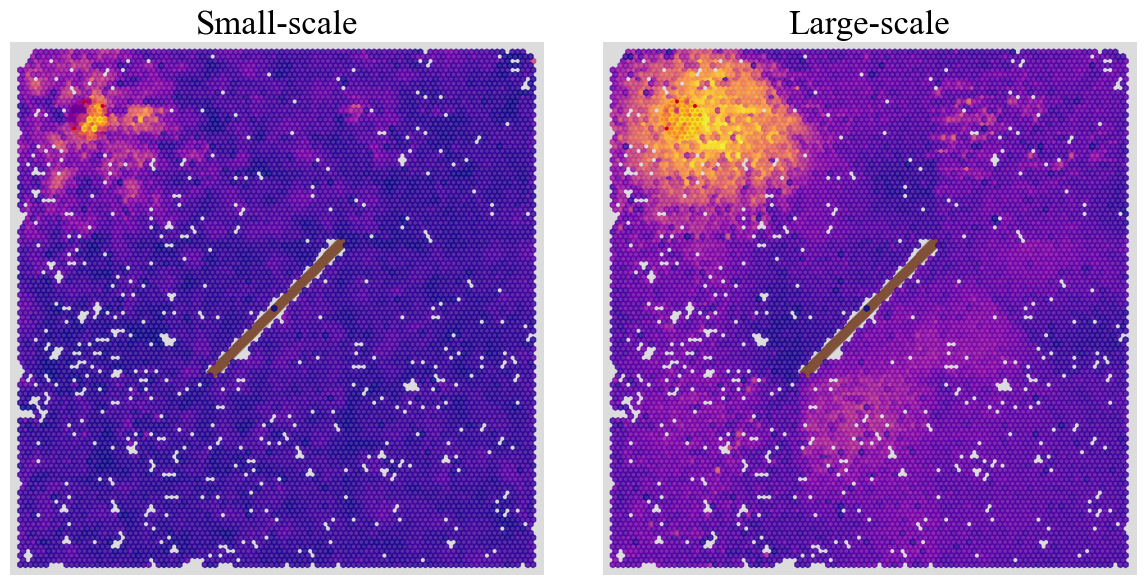

In [5]:
import tensorflow as tf

rcParams['font.family'] = 'Times New Roman'

def plot_rcn_activations_grid(data, reward_cell_index, background_path, world_id, flip_axis=None, buffer=0.5):
    hmap_x = data['hmap_x']
    hmap_y = data['hmap_y']
    cmap = get_cmap("plasma")

    layers = ["small", "large"]
    n_layers = len(layers)

    img = Image.open(background_path)
    if flip_axis == "vertical":
        img = ImageOps.flip(img)
    elif flip_axis == "horizontal":
        img = ImageOps.mirror(img)
    img = np.array(img)

    fig, axes = plt.subplots(1, n_layers, figsize=(12, 6))

    for i, layer in enumerate(layers):
        ax = axes[i]

        if layer == "small":
            rc_net = data.get("rc_net_small")
            hmap_z = data['hmap_z_small']
            scale = "Small-scale"
        elif layer == "large":
            if not data.get('has_large_pcn', False):
                print("Large layer not available. Skipping visualization.")
                continue
            rc_net = data.get("rc_net_large")
            hmap_z = data.get("hmap_z_large")
            scale = "Large-scale"
        else:
            raise ValueError("Layer must be either 'small' or 'large'.")

        if rc_net is None:
            print(f"No RCN data found for layer: {layer}")
            continue

        hmap_z_tf = tf.cast(hmap_z, tf.float32)
        w_in_effective = tf.cast(rc_net.w_in_effective[reward_cell_index], tf.float32)

        if w_in_effective.shape[0] != hmap_z_tf.shape[1]:
            print(f"Adjusting w_in_effective shape: {w_in_effective.shape} -> {hmap_z_tf.shape[1]}")
            w_in_effective = w_in_effective[:hmap_z_tf.shape[1]]

        reward_function = tf.tensordot(w_in_effective, tf.transpose(hmap_z_tf), axes=1)
        reward_function = tf.squeeze(reward_function).numpy()

        extent = [
            hmap_x.min() - buffer, hmap_x.max() + buffer,
            hmap_y.min() - buffer, hmap_y.max() + buffer,
        ]

        ax.imshow(img, extent=extent, aspect='auto')
        ax.set_aspect("equal")

        cntr = ax.hexbin(hmap_x, hmap_y, reward_function, gridsize=100, cmap=cmap, alpha=0.8)

        ax.set_title(f"{scale.capitalize()}", fontsize=25)
        ax.set_axis_off()

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    plt.show()


# Example usage
background_path = "images/world0_20x20-obstacles.png"
plot_rcn_activations_grid(
    data=data,
    reward_cell_index=0,
    background_path=background_path,
    world_id="world0_20x20-2obstacles",
    flip_axis="vertical",
    buffer=0.4
)

# Plot Gradients

In [6]:
import plotly.graph_objects as go
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

def plot_rcn_gradient_3d_interactive(scale='blended', world_id="unspecified_world", smoothing_sigma=0):
    """Plots the gradient of the RCN activation map in 3D interactively using Plotly.
    
    For `scale='blended'`, combines small and large scales using gradient-based blending.
    """
    print(f"Starting plot_rcn_gradient_3d_interactive for scale: {scale}, world_id: {world_id}")

    # Select appropriate scales
    if scale in ['small', 'large']:
        rc_net = data.get(f'rc_net_{scale}', None)
        hmap_z = data.get(f'hmap_z_{scale}', None)
        if scale == 'small':
            scale_dir = "vanilla"
        else:
            scale_dir = "multiscale"
    elif scale == 'blended':
        rc_net_small = data.get('rc_net_small', None)
        hmap_z_small = data.get('hmap_z_small', None)
        rc_net_large = data.get('rc_net_large', None)
        hmap_z_large = data.get('hmap_z_large', None)
        if rc_net_small is None or hmap_z_small is None or rc_net_large is None or hmap_z_large is None:
            print("Missing data for blended scale. Ensure both small and large scale data are provided.")
            return
    else:
        raise ValueError("Scale must be 'small', 'large', or 'blended'.")

    # Ensure data is loaded
    if scale in ['small', 'large']:
        if rc_net is None or hmap_z is None:
            print(f"Could not find RCN or activation data for the '{scale}' scale.")
            return

    print("RCN data and activation maps loaded successfully.")

    # Calculate reward function for small and large scales
    def compute_reward_function(rc_net, hmap_z):
        hmap_x = np.array(data['hmap_x'])
        hmap_y = np.array(data['hmap_y'])
        reward_cell_index = 0
        hmap_z_tf = tf.cast(hmap_z, tf.float32)
        w_in_effective = rc_net.w_in_effective[reward_cell_index]
        sum_activations = tf.reduce_sum(hmap_z_tf, axis=1)
        safe_denominator = tf.where(sum_activations > 0, sum_activations, 1.0)
        safe_denominator = tf.cast(safe_denominator, tf.float32)
        hmap_z_t = tf.transpose(hmap_z_tf)
        reward_function = tf.tensordot(w_in_effective, hmap_z_t, axes=1)
        reward_function /= safe_denominator
        reward_function = tf.squeeze(reward_function).numpy()
        return reward_function, hmap_x, hmap_y

    if scale == 'blended':
        reward_function_small, hmap_x_small, hmap_y_small = compute_reward_function(rc_net_small, hmap_z_small)
        reward_function_large, hmap_x_large, hmap_y_large = compute_reward_function(rc_net_large, hmap_z_large)

        # Compute gradients for blending
        grad_small = np.sum(np.abs(np.gradient(reward_function_small)))
        grad_large = np.sum(np.abs(np.gradient(reward_function_large)))
        alpha = grad_small / (grad_small + grad_large + 1e-6)

        print(f"Blending scales with alpha={alpha:.2f} (small scale weight).")

        # Blend the reward functions
        reward_function_blended = alpha * reward_function_small + (1 - alpha) * reward_function_large

        # Use coordinates from small scale for interpolation
        hmap_x = hmap_x_small
        hmap_y = hmap_y_small
        reward_function = reward_function_blended
    else:
        reward_function, hmap_x, hmap_y = compute_reward_function(rc_net, hmap_z)

    # Ensure valid data points for interpolation
    valid_mask = ~np.isnan(reward_function)
    hmap_x_valid = hmap_x[valid_mask]
    hmap_y_valid = hmap_y[valid_mask]
    reward_function_valid = reward_function[valid_mask]

    if len(hmap_x_valid) < 3 or len(hmap_y_valid) < 3:
        print("Insufficient valid data points for interpolation. Exiting.")
        return

    # Reshape to a grid
    grid_x, grid_y = np.linspace(hmap_x.min(), hmap_x.max(), 100), np.linspace(hmap_y.min(), hmap_y.max(), 100)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)
    reward_function_grid = griddata(
        (hmap_x_valid, hmap_y_valid), reward_function_valid, (grid_x, grid_y), method='cubic'
    )

    if reward_function_grid is None or np.isnan(reward_function_grid).all():
        print("Interpolated reward function contains NaN values or failed.")
        return

    print("Interpolated reward function to 2D grid successfully.")

    # Fill NaN values with nearest neighbor interpolation as a fallback
    reward_function_grid = np.nan_to_num(reward_function_grid, nan=np.nanmean(reward_function_valid))

    # Apply Gaussian smoothing
    reward_function_grid_smoothed = gaussian_filter(reward_function_grid, sigma=smoothing_sigma)
    print("Applied Gaussian smoothing to reward function grid.")

    # Plot the 3D surface interactively using Plotly
    fig = go.Figure()

    fig.add_trace(go.Surface(
        z=reward_function_grid_smoothed,
        x=grid_x,
        y=grid_y,
        colorscale="Viridis",
        showscale=True,
    ))

    # Update layout for better interactivity
    fig.update_layout(
        title=f"{scale.capitalize()} Gradient Map in 3D (Smoothed)",
        scene=dict(
            xaxis_title="X Coordinate",
            yaxis_title="Y Coordinate",
            zaxis_title="Reward Value",
        ),
        margin=dict(l=0, r=0, t=50, b=0),
    )

    # Display the plot
    fig.show()
    print("Interactive 3D Gradient plot displayed successfully.")


# # Example calls
# plot_rcn_gradient_3d_interactive(scale='small', world_id="world20x20", smoothing_sigma=2)
# plot_rcn_gradient_3d_interactive(scale='large', world_id="world20x20", smoothing_sigma=2)
# plot_rcn_gradient_3d_interactive(scale='blended', world_id="world20x20", smoothing_sigma=2)


# Plot Path Heatmaps

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_corner_heatmaps(data, path_type="multiscale", world_id="world0_20x20", bins=100):
    """
    Plot heatmaps showing path density for each corner in the environment.
    
    Parameters:
    - data: Dictionary containing path data
    - path_type: Either "vanilla" or "multiscale"
    - world_id: ID of the world being plotted
    - bins: Number of bins for the 2D histogram
    """
    paths_data = data["vanilla_hmaps"] if path_type == "vanilla" else data["multiscale_hmaps"]
    
    corners = list(paths_data.keys())  # Get available corners
    num_corners = len(corners)
    goal_location = data['goal_location']
    goal_r = data['goal_r']
    
    # Determine subplot grid based on the number of corners
    fig, axs = plt.subplots(1, num_corners, figsize=(15, 5))  # Single row layout
    if num_corners == 1:
        axs = [axs]  # Ensure axs is iterable for single subplot

    # Process each corner
    for ax, corner_id in zip(axs, corners):
        corner_x, corner_y = map(int, corner_id.split('_'))
        
        # Collect all path points for this corner
        all_x = []
        all_y = []
        for trial_id, hmaps in paths_data[corner_id].items():
            all_x.extend(hmaps["hmap_x"][1:])  # Skip first point
            all_y.extend(hmaps["hmap_y"][1:])
        
        # Create heatmap using 2D histogram
        heatmap, xedges, yedges = np.histogram2d(
            all_x, all_y, 
            bins=bins, 
            range=[[-10, 10], [-10, 10]]
        )
        
        # Plot heatmap
        im = ax.imshow(
            heatmap.T,
            extent=[-10, 10, -10, 10],
            origin='lower',
            cmap='viridis',
            aspect='equal',
            interpolation='nearest'
        )
        
        # Add boundary rectangle
        ax.add_patch(Rectangle((-10, -10), 20, 20, fill=False, color='gray', alpha=0.5))
        

        goal_circle = plt.Circle(goal_location, goal_r, color='green', alpha=1, fill=True)
        ax.add_patch(goal_circle)
        
        # Customize subplot
        ax.set_xlim(-10, 10)
        ax.set_ylim(-10, 10)
        ax.set_title(f'Corner ({corner_x}, {corner_y})')
        
        # Add colorbar
        plt.colorbar(im, ax=ax, label='Path Density')
    
    # Overall plot settings
    fig.suptitle(f'{"Vanilla" if path_type == "vanilla" else "Multiscale"} Path Density - {world_id}', 
                 fontsize=16)
    
    # Adjust layout
    plt.tight_layout()
    
    plt.show()

# Example usage:
# For multiscale heatmaps
# plot_corner_heatmaps(data, path_type="multiscale")
# plot_corner_heatmaps(data, path_type="vanilla")


# Plot Paths on Background

In [8]:
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from PIL import ImageOps
import matplotlib.pyplot as plt


def plot_background_with_paths(background_path, rotation_angle=0, 
                               path_data=None, path_type="multiscale", 
                               selected_corners=None, selected_trials=None,
                               plot_type_folder="trajectory_plots"):
    """
    Plots paths from a specified dataset over a rotated background PNG with an alpha gradient,
    displays the plot, and saves it to a specific directory structure.
    
    Args:
    - background_path (str): Path to the PNG file to use as the background.
    - rotation_angle (float): The angle to rotate the background image (in degrees).
    - path_data (dict): Path data dictionary containing vanilla/multiscale paths.
    - path_type (str): Type of paths to overlay ('vanilla' or 'multiscale').
    - selected_corners (list): List of corner IDs to include (e.g., ["8_-8", "0_-8"]). If None, include all.
    - selected_trials (list): List of trial IDs to include (e.g., ["1", "2"]). If None, include all trials.
    - plot_type_folder (str): Subfolder name to save plots (e.g., 'gradient', 'trajectory').
    """
    def interpolate_alpha(alpha_values):
        """Fill in zeros in the alpha values with the previous non-zero value."""
        interpolated = np.copy(alpha_values)
        last_nonzero = 0
        for i in range(len(alpha_values)):
            if alpha_values[i] != 0:
                last_nonzero = alpha_values[i]
            else:
                interpolated[i] = last_nonzero
        return interpolated

    # Initialize normalization
    norm = Normalize(vmin=0, vmax=1)

    # Load and rotate the background image
    img = Image.open(background_path)
    img = ImageOps.flip(img)  # Mirror the image horizontally (y-axis reflection)
    img = np.array(img)

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(img, extent=[-10, 10, -10, 10], aspect='auto')  # Adjust extent if needed
    ax.set_aspect("equal")

    # Add grid and labels for coordinates
    ax.set_xticks(np.arange(-10, 11, 2))  # X ticks from -10 to 10 with step 2
    ax.set_yticks(np.arange(-10, 11, 2))  # Y ticks from -10 to 10 with step 2

    # Optionally overlay paths
    alpha_exists = False  # Track if any alpha_values exist
    if path_data:
        paths_data = path_data["vanilla_hmaps"] if path_type == "vanilla" else path_data["multiscale_hmaps"]
        
        # Filter selected corners
        filtered_corners = selected_corners if selected_corners else paths_data.keys()

        for corner_id in filtered_corners:
            if corner_id not in paths_data:
                print(f"Corner {corner_id} not found in {path_type} data.")
                continue
            
            trials = paths_data[corner_id]
            
            # Filter selected trials
            filtered_trials = selected_trials if selected_trials else trials.keys()

            for trial_id in filtered_trials:
                if trial_id not in trials:
                    print(f"Trial {trial_id} not found for corner {corner_id}.")
                    continue
                
                hmaps = trials[trial_id]
                x_coords = hmaps["hmap_x"][1:]  # Disregard the first value
                y_coords = hmaps["hmap_y"][1:]  # Disregard the first value

                # Check if alpha exists
                alpha_values = hmaps.get("hmap_alpha", None)
                if alpha_values is not None:
                    alpha_values = alpha_values[1:]  # Disregard the first value
                    
                    # Interpolate alpha values
                    alpha_values = interpolate_alpha(alpha_values)
                    
                    # Normalize alpha values for color mapping
                    alpha_exists = True
                    colors = plt.cm.plasma(norm(alpha_values))  # Choose a colormap
                    
                    # Create line segments with blending
                    points = np.array([x_coords, y_coords]).T.reshape(-1, 1, 2)
                    segments = np.concatenate([points[:-1], points[1:]], axis=1)
                    lc = LineCollection(segments, cmap='plasma', linewidth=2, alpha=1.0)
                    lc.set_array(alpha_values)  # Use alpha values for color blending
                    
                    # Add the gradient path to the plot
                    ax.add_collection(lc)
                else:
                    # Default path without alpha gradient
                    ax.plot(x_coords, y_coords, '-', color='blue', alpha=0.7, 
                            label=f'Trial {trial_id} (Corner {corner_id})')

                # Mark start and end points
                ax.plot(x_coords[0], y_coords[0], 'o', color='black', markersize=4, label='Start')

    # Add a colorbar legend for the gradient if alpha exists
    if alpha_exists:
        sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
        sm.set_array([])  # Dummy array for the colorbar
        cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label('Alpha Gradient', fontsize=10)

    # Add title

    # Show the plot
    plt.show()

    # Save the plot
    save_plot_to_directory(fig, background_path, path_type, plot_type_folder, corner_id)

    # Close the plot to free memory
    plt.close(fig)

# background_path = "images/world0_20x20-goalBehindWall-corner_0.png"
background_path = "images/world0_20x20-obstacles.png"

# # Example usage with corners read from hmap names
# corners = list(data["multiscale_hmaps"].keys())
# print(corners)
# for corner in corners:
#     plot_background_with_paths(
#         background_path=background_path,
#         rotation_angle=270,
#         path_data=data,
#         path_type="multiscale",
#         selected_corners=[corner]
#     )

# for corner in corners:
#     plot_background_with_paths(
#         background_path=background_path,
#         rotation_angle=270,
#         path_data=data,
#         path_type="vanilla",
#         selected_corners=[corner]
#     )

# Plot Paths Side By Side

Saved plot to analysis/stats\multiscale\world0_20x20-obstacles\trajectory_plots\sidebyside\corner_8_-8.png


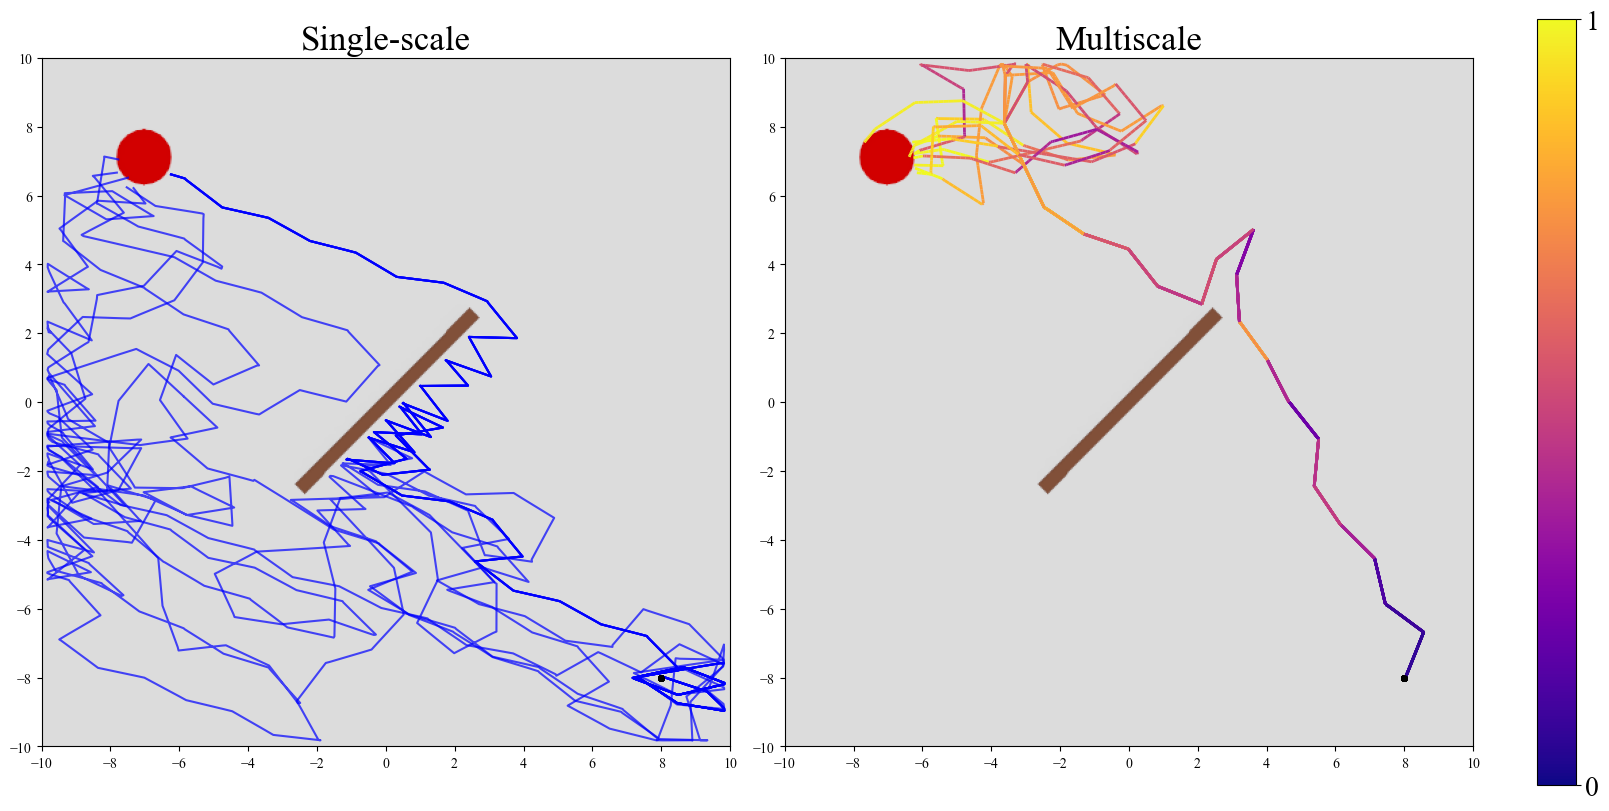

Saved plot to analysis/stats\multiscale\world0_20x20-obstacles\trajectory_plots\sidebyside\corner_0_-8.png


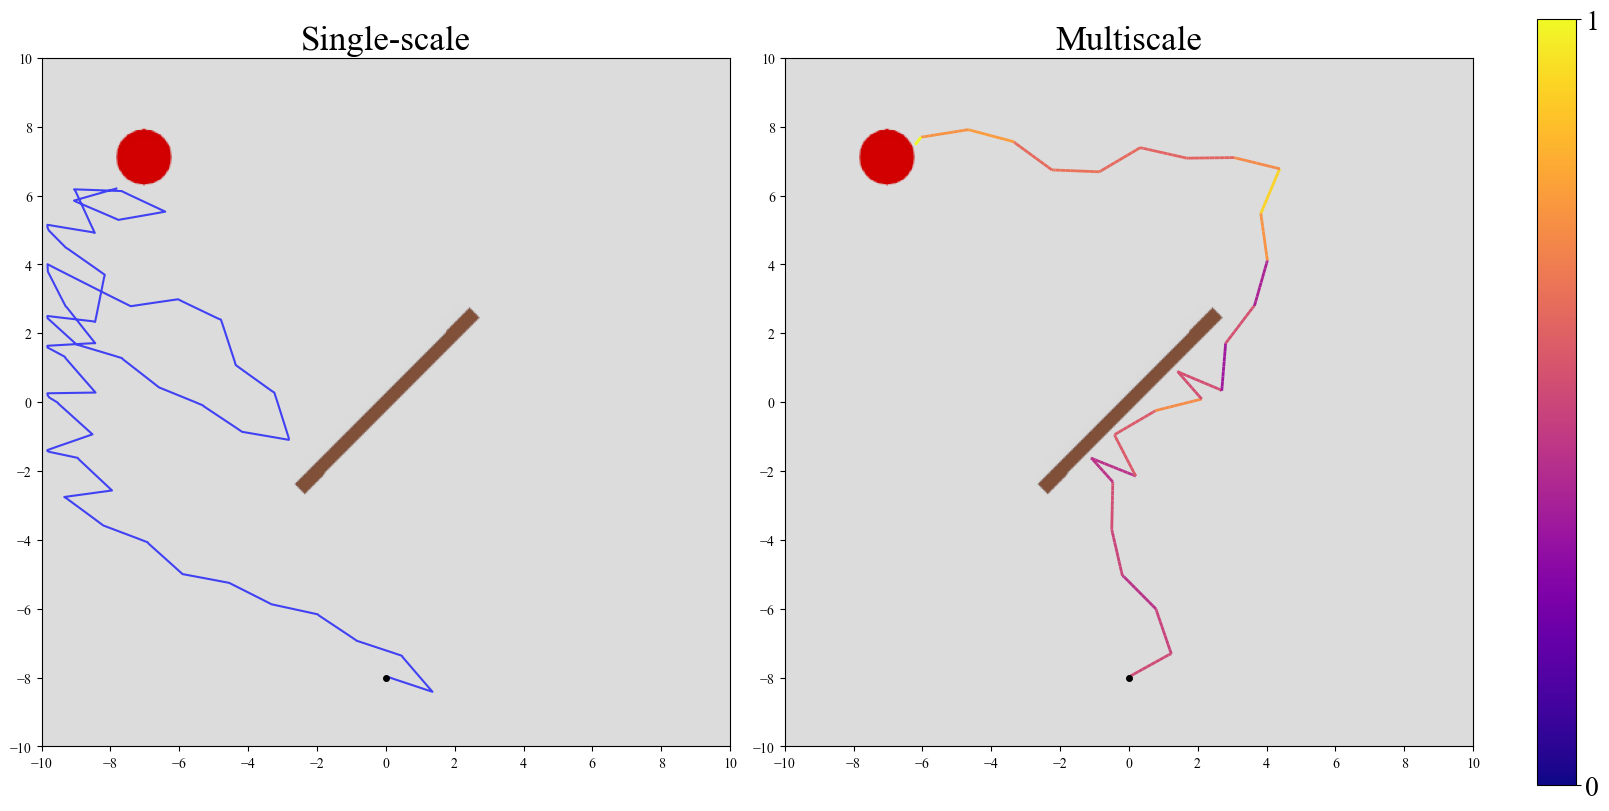

Saved plot to analysis/stats\multiscale\world0_20x20-obstacles\trajectory_plots\sidebyside\corner_2_-2.png


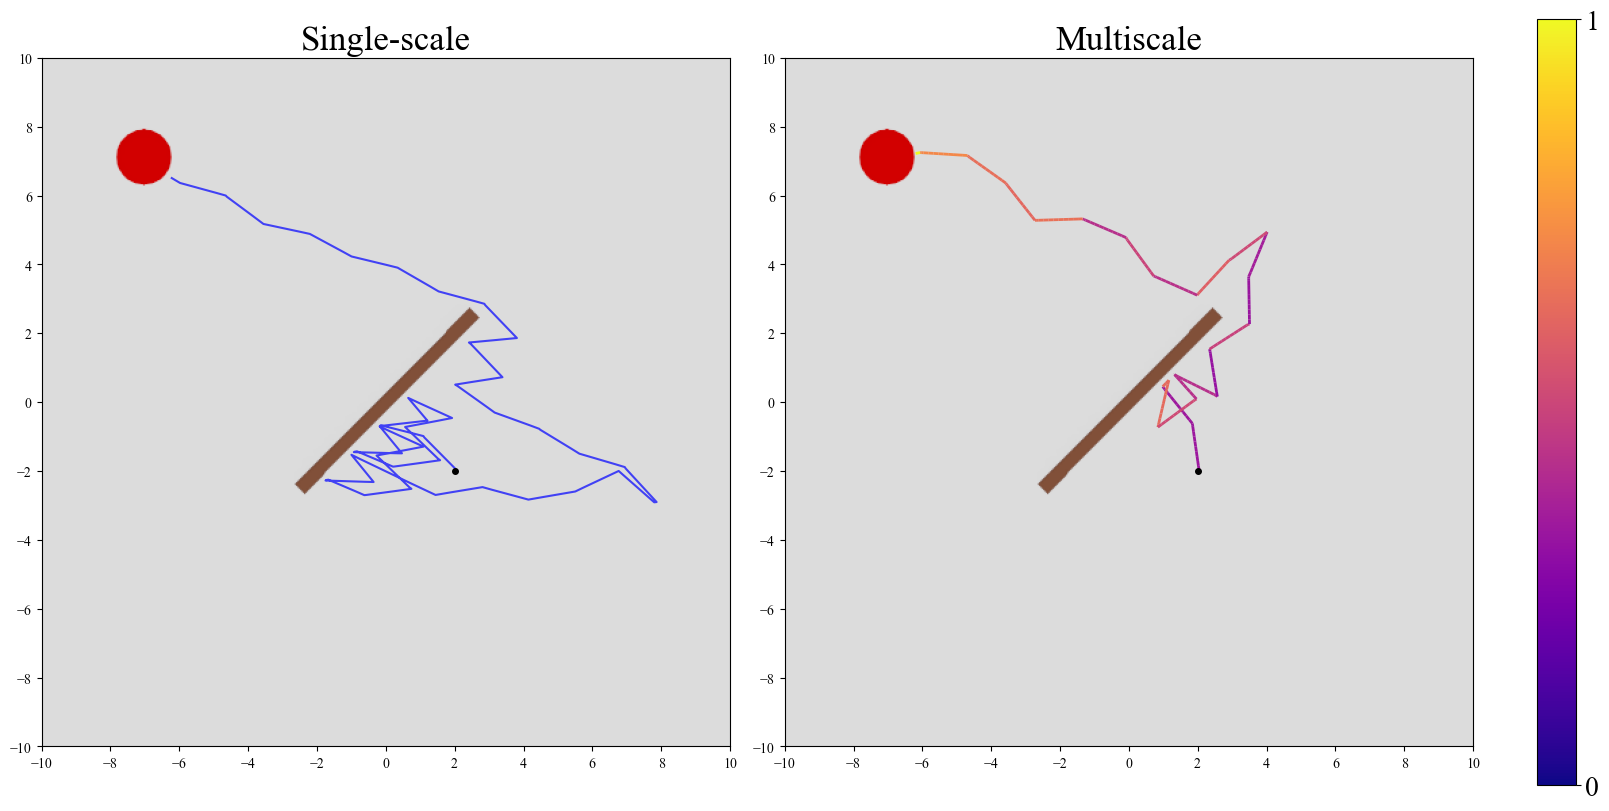

Saved plot to analysis/stats\multiscale\world0_20x20-obstacles\trajectory_plots\sidebyside\corner_8_0.png


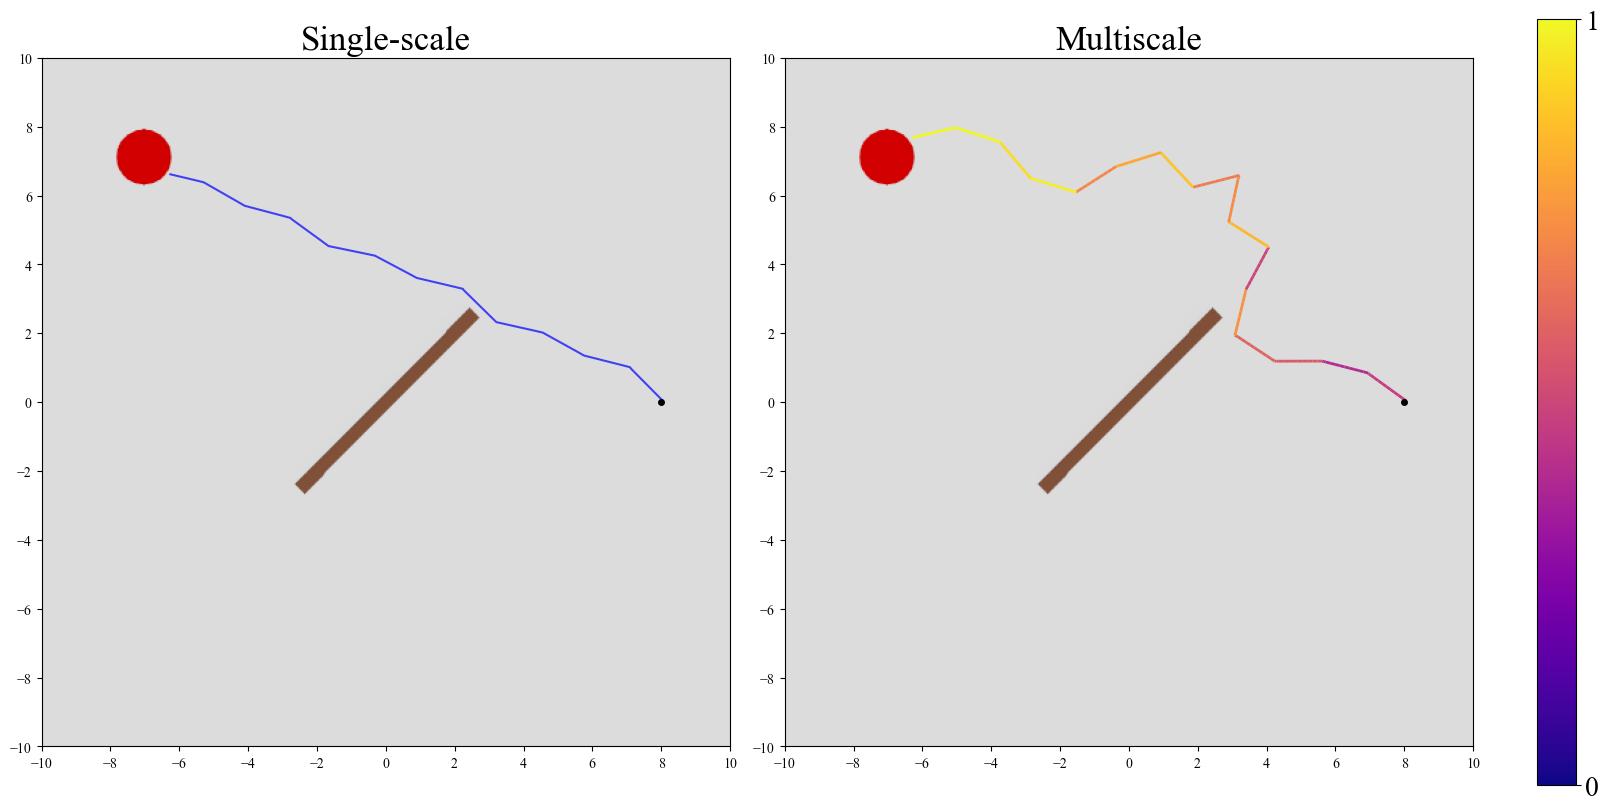

In [9]:
import os

def plot_background_with_side_by_side_paths(background_path, 
                                            path_data=None, selected_corners=None, 
                                            save_dir="analysis/stats"):
    def interpolate_alpha(alpha_values):
        interpolated = np.copy(alpha_values)
        last_nonzero = 0
        for i in range(len(alpha_values)):
            if alpha_values[i] != 0:
                last_nonzero = alpha_values[i]
            else:
                interpolated[i] = last_nonzero
        return interpolated

    norm = Normalize(vmin=0, vmax=1)
    img = Image.open(background_path)
    img = ImageOps.flip(img)
    img = np.array(img)
    world_name = os.path.basename(background_path).split('.')[0]

    filtered_corners = selected_corners if selected_corners else path_data["multiscale_hmaps"].keys()

    for corner_id in filtered_corners:
        fig, axes = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)
        titles = ["Single-scale", "Multiscale"]
        path_types = ["vanilla_hmaps", "multiscale_hmaps"]

        for i, (ax, path_type) in enumerate(zip(axes, path_types)):
            ax.imshow(img, extent=[-10, 10, -10, 10], aspect='auto')
            ax.set_xticks(np.arange(-10, 11, 2))
            ax.set_yticks(np.arange(-10, 11, 2))
            ax.set_aspect("equal")
            ax.set_title(f"{titles[i]}", fontsize=25)

            if corner_id not in path_data[path_type]:
                print(f"Corner {corner_id} not found in {titles[i]} data.")
                continue

            trials = path_data[path_type][corner_id]

            for trial_id, hmaps in trials.items():
                x_coords = hmaps["hmap_x"][1:]
                y_coords = hmaps["hmap_y"][1:]
                alpha_values = hmaps.get("hmap_alpha", None)

                if alpha_values is not None:
                    alpha_values = alpha_values[1:]
                    alpha_values = interpolate_alpha(alpha_values)
                    points = np.array([x_coords, y_coords]).T.reshape(-1, 1, 2)
                    segments = np.concatenate([points[:-1], points[1:]], axis=1)
                    lc = LineCollection(segments, cmap='plasma', linewidth=2, alpha=1.0)
                    lc.set_array(alpha_values)
                    ax.add_collection(lc)
                else:
                    ax.plot(x_coords, y_coords, '-', color='blue', alpha=0.7)

                ax.plot(x_coords[0], y_coords[0], 'o', color='black', markersize=4)

        sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.046, pad=0.04)
        cbar.ax.set_yticks([0, 1])
        cbar.ax.tick_params(labelsize=20)

        save_path = os.path.join(
            save_dir, 
            titles[i].lower(), 
            world_name, 
            "trajectory_plots", 
            "sidebyside"
        )
        os.makedirs(save_path, exist_ok=True)
        fig_path = os.path.join(save_path, f"corner_{corner_id}.png")
        fig.savefig(fig_path, dpi=300)
        print(f"Saved plot to {fig_path}")

        plt.show()

        plt.close(fig)


# Example usage
corners = list(data["multiscale_hmaps"].keys())
plot_background_with_side_by_side_paths(
    background_path="images/world0_20x20-obstacles.png",
    path_data=data,
    selected_corners=corners
)


# Plot All Paths

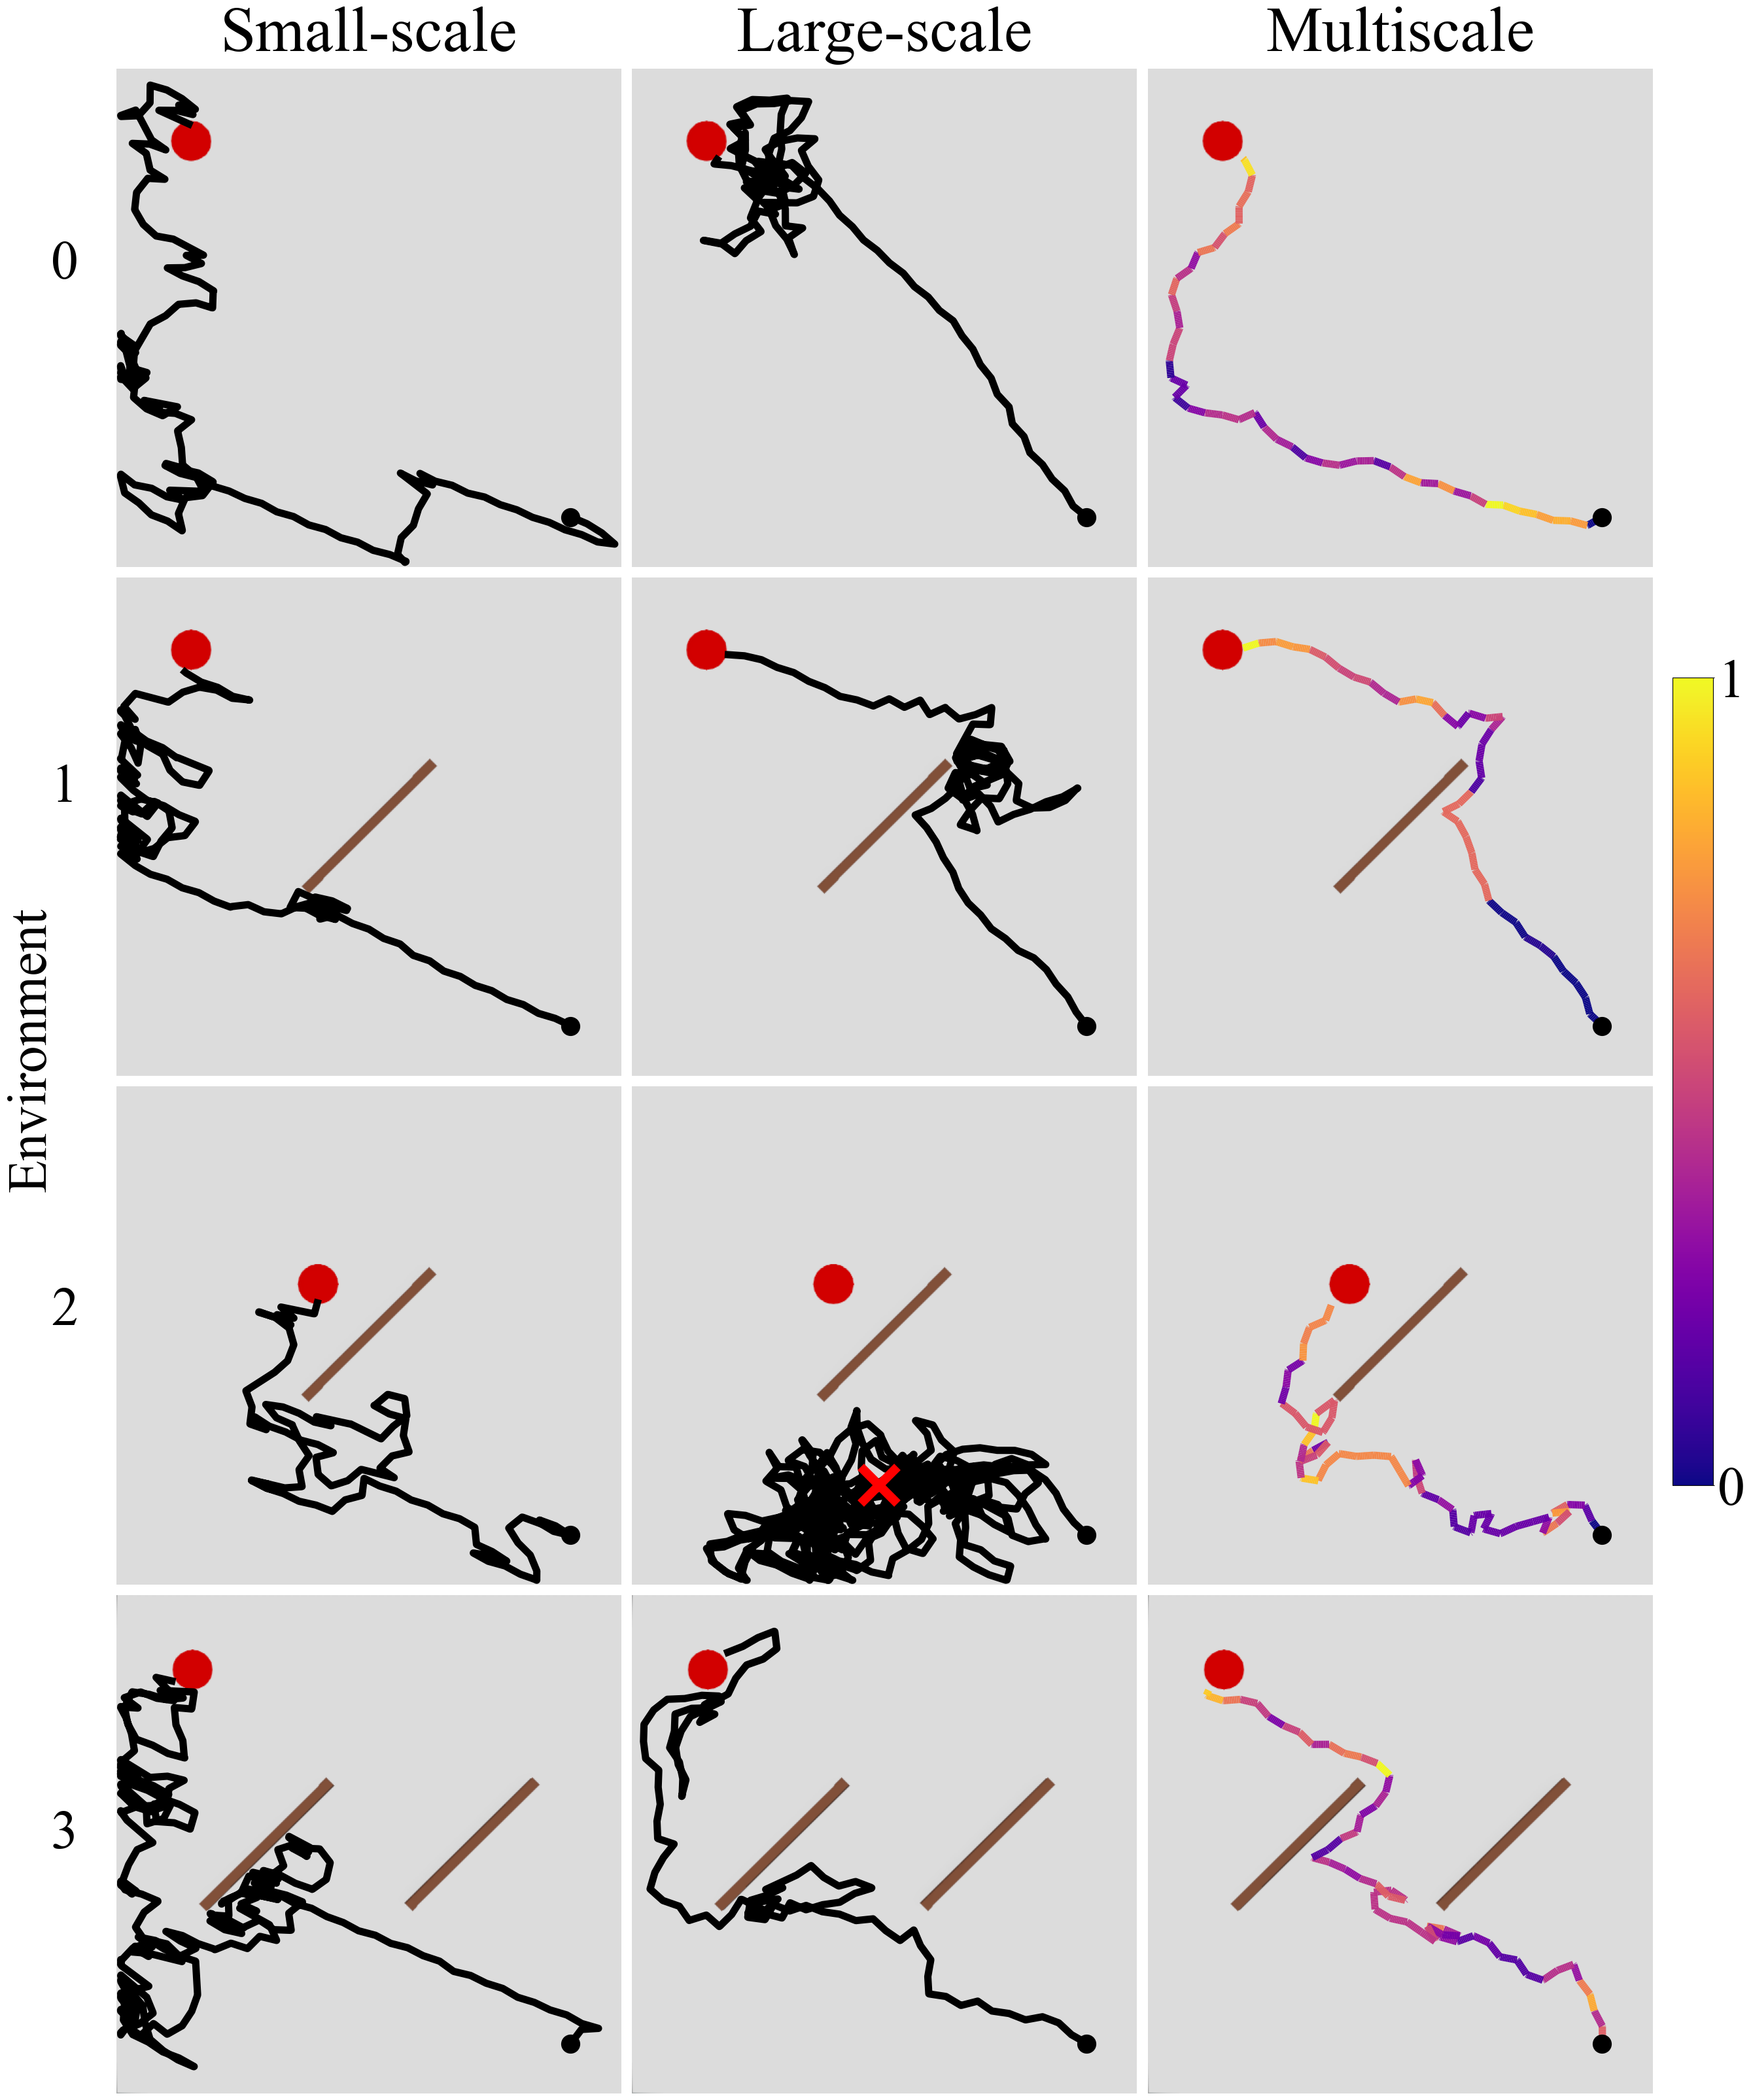

In [53]:
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib import rcParams
from matplotlib.patches import Rectangle  # (still imported in case you need it elsewhere)

rcParams['font.family'] = 'Times New Roman'

def plot_corner_across_worlds_and_models(corner_id, world_names, background_paths, 
                                           base_dir="analysis/stats", trial_mapping=None):
    """
    Plots the path from a specified corner across multiple worlds and models.
    
    Parameters:
        corner_id (str): The corner identifier (e.g., "8,-8").
        world_names (list): List of world/environment names.
        background_paths (list): List of file paths for the background images corresponding to each world.
        base_dir (str): The base directory where the stats/hmap data is stored.
        trial_mapping (dict, optional): A dictionary mapping (model_name, world_name) tuples to a trial number.
                                        For example: { ("vanilla", "world0_20x20"): 2, ("multiscale", "world0_20x20"): 1 }
                                        If a given pair is not found, trial 1 is used by default.
    """
    
    def interpolate_alpha(alpha_values):
        interpolated = np.copy(alpha_values)
        last_nonzero = 0
        for i in range(len(alpha_values)):
            if alpha_values[i] != 0:
                last_nonzero = alpha_values[i]
            else:
                interpolated[i] = last_nonzero
        return interpolated

    norm = Normalize(vmin=0, vmax=1)
    
    # Define three models. The order here determines the column order.
    model_names = ["vanilla", "large_scale", "multiscale"]
    num_models = len(model_names)
    
    # Adjust figure width for three columns.
    fig, axes = plt.subplots(len(world_names), num_models, figsize=(25, 8 * len(world_names)), constrained_layout=True)

    # If there is only one world (row), ensure axes is 2D for consistency.
    if len(world_names) == 1:
        axes = np.expand_dims(axes, axis=0)
    
    # Add column labels (titles)
    for col_idx, model_name in enumerate(model_names):
        if model_name == "vanilla":
            title = "Small-scale"
        elif model_name == "large_scale":
            title = "Large-scale"
        elif model_name == "multiscale":
            title = "Multiscale"
        axes[0, col_idx].set_title(title, fontsize=70, pad=20)

    for row_idx, (world_name, background_path) in enumerate(zip(world_names, background_paths)):
        # Load and flip the background image for the current world/environment.
        img = Image.open(background_path)
        img = ImageOps.flip(img)
        img = np.array(img)

        for col_idx, model_name in enumerate(model_names):
            ax = axes[row_idx, col_idx]
            ax.imshow(img, extent=[-10, 10, -10, 10], aspect='auto')

            # (Previously: a rectangle patch with hatch for large_scale in goalBehindWall was added.
            # Now we will mark the endpoint with an "X" later.)

            # Remove axis ticks, labels, and borders.
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_visible(False)

            # Determine which trial to use.
            trial = "1"
            if trial_mapping is not None:
                trial = str(trial_mapping.get((model_name, world_name), "1"))
            
            # Construct the filename for the corner path.
            # Note: We replace commas in the corner_id with underscores for the file name.
            corner_fname = f"trial_{trial}_corner_{corner_id.replace(',', '_')}"
            path_dir = os.path.join(base_dir, model_name, world_name, "hmaps")
            hmap_x_file = os.path.join(path_dir, f"{corner_fname}_hmap_x.pkl")
            hmap_y_file = os.path.join(path_dir, f"{corner_fname}_hmap_y.pkl")
            alpha_file = os.path.join(path_dir, f"{corner_fname}_hmap_alpha.pkl")
            
            if not os.path.exists(hmap_x_file) or not os.path.exists(hmap_y_file):
                print(f"Missing data for {model_name} in {world_name} for trial {trial}")
                continue

            with open(hmap_x_file, "rb") as f:
                x_coords = pickle.load(f)
            with open(hmap_y_file, "rb") as f:
                y_coords = pickle.load(f)

            alpha_values = None
            if os.path.exists(alpha_file):
                with open(alpha_file, "rb") as f:
                    alpha_values = pickle.load(f)

            # Plot the path.
            if model_name == "vanilla" or model_name == "large_scale":
                ax.plot(x_coords[1:], y_coords[1:], '-', color='black', linewidth=8, alpha=1.0)
            else:  # For multiscale
                if alpha_values is not None:
                    alpha_values = interpolate_alpha(alpha_values)
                    # Prepare segments for a colored line using the plasma colormap.
                    points = np.array([x_coords[1:], y_coords[1:]]).T.reshape(-1, 1, 2)
                    segments = np.concatenate([points[:-1], points[1:]], axis=1)
                    lc = LineCollection(segments, cmap='plasma', linewidth=8, alpha=1.0)
                    lc.set_array(alpha_values[1:])
                    ax.add_collection(lc)
                else:
                    # Fallback: plot a line with reduced opacity.
                    ax.plot(x_coords[1:], y_coords[1:], '-', alpha=0.7, label=model_name)

            # Mark a point:
            # For world "world0_20x20-goalBehindWall" with the "large_scale" model, mark the endpoint with an X.
            if world_name == "world0_20x20-goalBehindWall" and model_name == "large_scale":
                ax.plot(x_coords[1], y_coords[1], 'o', color='black', markersize=20)
                ax.plot(x_coords[-1], y_coords[-1], 'x', color='red', markersize=40, markeredgewidth=10)
            else:
                # For all other cases, mark the starting point.
                ax.plot(x_coords[1], y_coords[1], 'o', color='black', markersize=20)

        # Add an integer label for each world along the left side of the figure.
        fig.text(
            -0.03,  # X-coordinate (close to the left edge)
            1 - (row_idx + 0.5) / len(world_names),  # Y-coordinate (center of the row)
            str(row_idx),  # Index text
            fontsize=60, 
            ha='center', 
            va='center',
            color="black"
        )

    # Add a vertical label on the left side for "Environment"
    fig.text(
        -0.05,  # X-coordinate (very close to the left edge)
        0.5,    # Y-coordinate (center vertically)
        "Environment",  # Label text
        fontsize=60, 
        ha="center", 
        va="center", 
        rotation="vertical"
    )

    # Add a single colorbar for the paths using the plasma colormap (applied on the last column).
    sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes[:, -1], orientation='vertical', fraction=0.08, pad=0.04)
    cbar.ax.tick_params(labelsize=60, length=1.3)
    cbar.set_ticks([0, 1])
    cbar.ax.set_yticklabels(['0', '1'])

    plt.show()

# Example usage:
corner_id = "8,-8"
world_names = [
    "world0_20x20",
    "world0_20x20-obstacles",
    "world0_20x20-goalBehindWall",
    "world0_20x20-2obstacles"
]
background_paths = [
    "images/world0_20x20.png",
    "images/world0_20x20-obstacles.png",
    "images/world0_20x20-goalBehindWall.png",
    "images/world0_20x20-2obstacles.png"
]

# Example trial_mapping: Specify which trial to use for each model and world.
trial_mapping = {
    ("vanilla", "world0_20x20"): 1,
    ("large_scale", "world0_20x20"): 2,
    ("multiscale", "world0_20x20"): 11,
    ("vanilla", "world0_20x20-goalBehindWall"): 4,
    ("multiscale", "world0_20x20-goalBehindWall"): 6,

    # Additional mappings can be added as needed.
}

plot_corner_across_worlds_and_models(corner_id, world_names, background_paths, trial_mapping=trial_mapping)


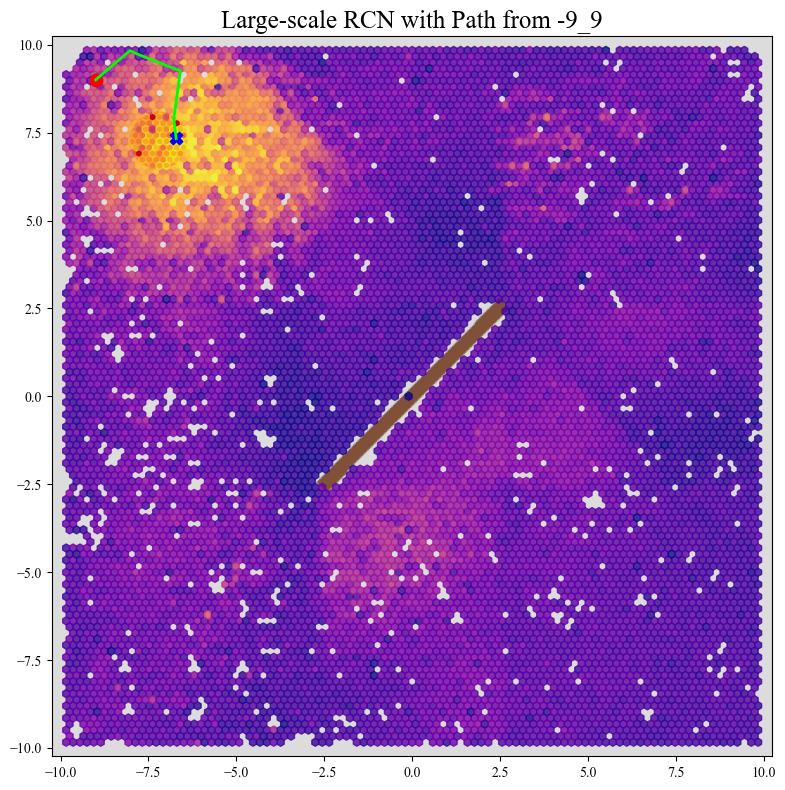

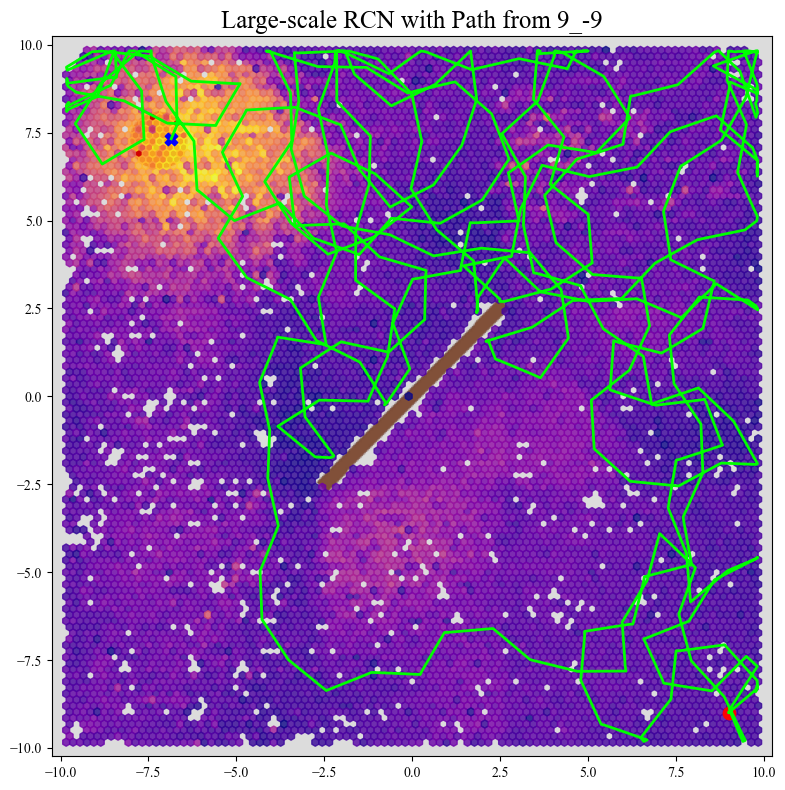

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from matplotlib import cm

def plot_rcn_activations_grid(data, reward_cell_index, background_path, world_id, flip_axis=None, buffer=0.5):
    """
    Plot the large-scale RCN activation over the arena and generate separate plots for each DMTP path.

    Parameters:
    - data: Dictionary containing environment and RCN data.
    - reward_cell_index: Index of the reward cell to visualize.
    - background_path: Path to the background arena image.
    - world_id: ID of the world being plotted.
    - flip_axis: "vertical" or "horizontal" to flip the image.
    - buffer: Extra margin around the arena extent.
    """
    hmap_x = data['hmap_x']
    hmap_y = data['hmap_y']
    cmap = cm.plasma

    # Load and process background image
    img = Image.open(background_path)
    if flip_axis == "vertical":
        img = ImageOps.flip(img)
    elif flip_axis == "horizontal":
        img = ImageOps.mirror(img)
    img = np.array(img)

    # Ensure large-scale RCN exists
    if not data.get('has_large_pcn', False) or "rc_net_large" not in data:
        print("Large-scale RCN not available. Skipping visualization.")
        return

    rc_net = data["rc_net_large"]
    hmap_z = data["hmap_z_large"]
    scale = "Large-scale"

    if rc_net is None or hmap_z is None:
        print(f"Skipping {scale} visualization (data missing).")
        return

    # Compute RCN activation
    hmap_z_tf = tf.cast(hmap_z, tf.float32)
    w_in_effective = tf.cast(rc_net.w_in_effective[reward_cell_index], tf.float32)

    # Ensure shape matches
    if w_in_effective.shape[0] != hmap_z_tf.shape[1]:
        w_in_effective = w_in_effective[: hmap_z_tf.shape[1]]

    reward_function = tf.tensordot(w_in_effective, tf.transpose(hmap_z_tf), axes=1)
    reward_function = tf.squeeze(reward_function).numpy()

    # Set plot extent
    extent = [
        hmap_x.min() - buffer, hmap_x.max() + buffer,
        hmap_y.min() - buffer, hmap_y.max() + buffer,
    ]

    # Generate a separate plot for each DMTP start position
    for corner_id, hmaps in data["dmtp_hmaps"].items():
        if "hmap_x" not in hmaps or "hmap_y" not in hmaps:
            print(f"Skipping {corner_id} - Missing hmap_x or hmap_y in dmtp_hmaps.")
            continue

        # Remove the very first entry before plotting
        path_x = hmaps["hmap_x"][1:]
        path_y = hmaps["hmap_y"][1:]

        # Create figure for this specific path
        fig, ax = plt.subplots(figsize=(8, 8))

        # Plot background arena image
        ax.imshow(img, extent=extent, aspect='auto')

        # Overlay RCN activation using hexbin
        hb = ax.hexbin(hmap_x, hmap_y, C=reward_function, gridsize=100, cmap=cmap, alpha=0.8)

        # Plot path
        ax.plot(path_x, path_y, color="lime", lw=2, label=f"Path from {corner_id}")

        # Mark start and end points
        ax.scatter(path_x[0], path_y[0], color="red", s=80, marker="o", label="Start")  # Start point (red circle)
        ax.scatter(path_x[-1], path_y[-1], color="blue", s=80, marker="X", label="End")  # End point (blue X)

        # Finalize plot
        ax.set_aspect("equal")
        ax.set_title(f"{scale} RCN with Path from {corner_id}", fontsize=18)
        plt.tight_layout()
        plt.show()


# Example usage
background_path = "images/world0_20x20-obstacles.png"
plot_rcn_activations_grid(
    data=data,
    reward_cell_index=0,
    background_path=background_path,
    world_id="world0_20x20-obstacles",
    flip_axis="vertical",
    buffer=0.4
)

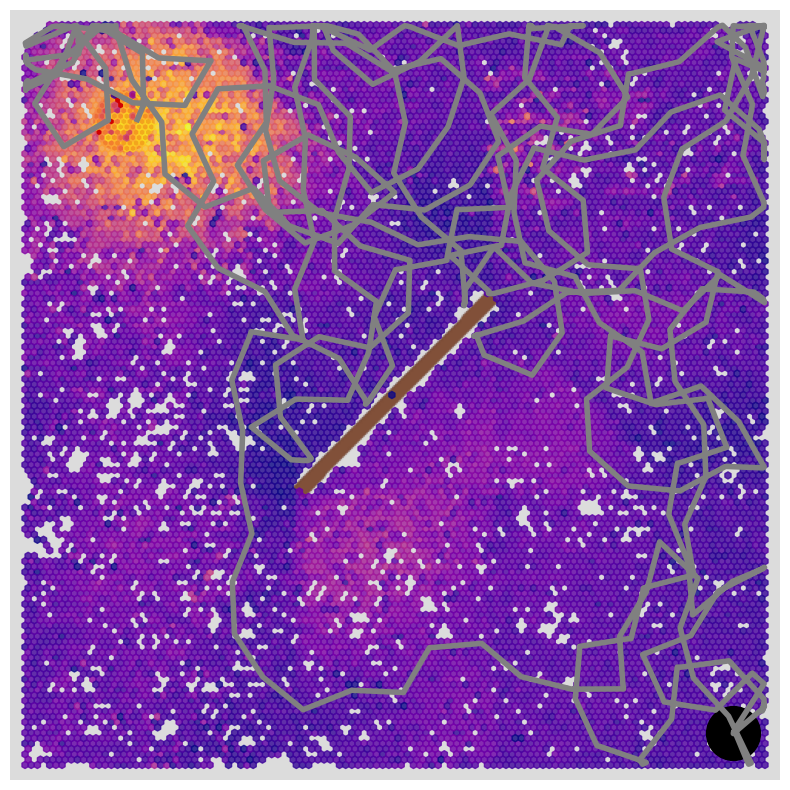

In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from matplotlib import cm

def plot_rcn_activations_grid(data, reward_cell_index, background_path, world_id, flip_axis=None, buffer=0.5):
    """
    Plot the large-scale RCN activation over the arena for the (9, -9) corner only, with no labels.

    Parameters:
    - data: Dictionary containing environment and RCN data.
    - reward_cell_index: Index of the reward cell to visualize.
    - background_path: Path to the background arena image.
    - world_id: ID of the world being plotted.
    - flip_axis: "vertical" or "horizontal" to flip the image.
    - buffer: Extra margin around the arena extent.
    """
    hmap_x = data['hmap_x']
    hmap_y = data['hmap_y']
    cmap = cm.plasma

    # Load and process background image
    img = Image.open(background_path)
    if flip_axis == "vertical":
        img = ImageOps.flip(img)
    elif flip_axis == "horizontal":
        img = ImageOps.mirror(img)
    img = np.array(img)

    # Ensure large-scale RCN exists
    if not data.get('has_large_pcn', False) or "rc_net_large" not in data:
        print("Large-scale RCN not available. Skipping visualization.")
        return

    rc_net = data["rc_net_large"]
    hmap_z = data["hmap_z_large"]

    if rc_net is None or hmap_z is None:
        print("Skipping visualization (data missing).")
        return

    # Compute RCN activation
    hmap_z_tf = tf.cast(hmap_z, tf.float32)
    w_in_effective = tf.cast(rc_net.w_in_effective[reward_cell_index], tf.float32)

    # Ensure shape matches
    if w_in_effective.shape[0] != hmap_z_tf.shape[1]:
        w_in_effective = w_in_effective[: hmap_z_tf.shape[1]]

    reward_function = tf.tensordot(w_in_effective, tf.transpose(hmap_z_tf), axes=1)
    reward_function = tf.squeeze(reward_function).numpy()

    # Set plot extent
    extent = [
        hmap_x.min() - buffer, hmap_x.max() + buffer,
        hmap_y.min() - buffer, hmap_y.max() + buffer,
    ]

    # Only plot the path for corner (9, -9)
    corner_id = "9_-9"
    if corner_id not in data["dmtp_hmaps"]:
        print(f"Skipping {corner_id} - No data available.")
        return

    hmaps = data["dmtp_hmaps"][corner_id]
    if "hmap_x" not in hmaps or "hmap_y" not in hmaps:
        print(f"Skipping {corner_id} - Missing hmap_x or hmap_y.")
        return

    # Remove the very first entry before plotting
    path_x = hmaps["hmap_x"][1:]
    path_y = hmaps["hmap_y"][1:]

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot background arena image
    ax.imshow(img, extent=extent, aspect='auto')

    # Overlay RCN activation using hexbin
    ax.hexbin(hmap_x, hmap_y, C=reward_function, gridsize=120, cmap=cmap, alpha=0.8)

    # Plot path
    ax.plot(path_x, path_y, color="gray", lw=4)

    # Mark start and end points
    ax.scatter(path_x[0], path_y[0], color="black", s=1500, marker="o")  # Start point (red circle)

    # Remove all labels, axis ticks, and title
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_frame_on(False)
    ax.set_axis_off()

    # Finalize plot
    plt.tight_layout()
    plt.show()


# Example usage
background_path = "images/world0_20x20-obstacles.png"
plot_rcn_activations_grid(
    data=data,
    reward_cell_index=0,
    background_path=background_path,
    world_id="world0_20x20-obstacles",
    flip_axis="vertical",
    buffer=0.4
)

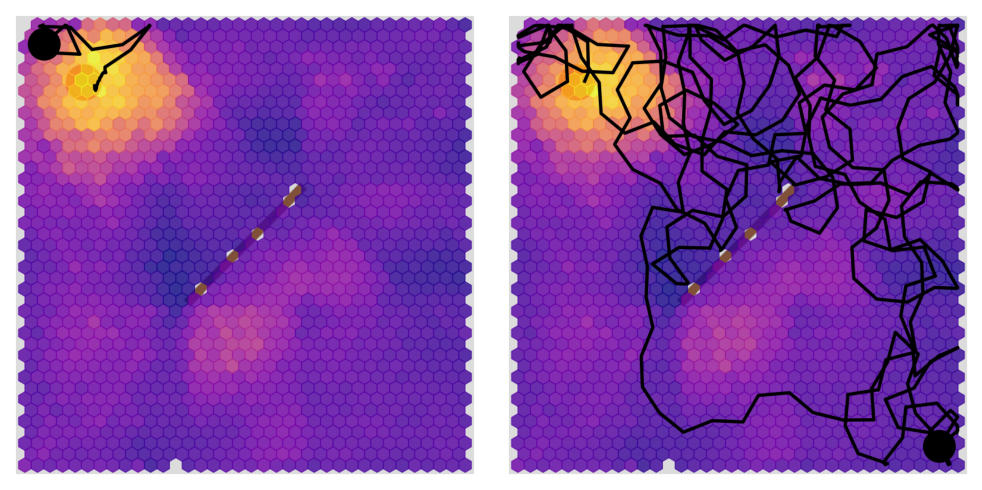

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load images
img1 = mpimg.imread("images\dmtp_0.png")
img2 = mpimg.imread("images\dmtp_1.png")

# Create figure and side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Display the first image
axes[0].imshow(img1)
axes[0].axis("off")  # Remove axes/ticks

# Display the second image
axes[1].imshow(img2)
axes[1].axis("off")  # Remove axes/ticks

# Adjust layout and show
plt.tight_layout()
plt.show()
